###**Import Necessary Libraries**

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import load_model
from keras.optimizers import SGD
from keras import backend as K
from PIL import Image

import tensorflow as tf
%tensorflow_version 1.x
import numpy as np, os, sys, pickle, gzip, urllib.request, time
import matplotlib.pyplot as plt
tf.logging.set_verbosity(tf.logging.ERROR)

###**Google Drive Authentication**

In [0]:
path = '/content/drive/My Drive/Project2/'
from google.colab import drive
drive.mount('/content/drive')
if not os.path.exists(path):
  os.makedirs(path)
os.chdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###**Generate Input and Label Vectors**

In [0]:
def get_data(filename, image_count):
    with gzip.open(filename) as file:
        file.read(16)
        buf = file.read(image_count * 28 * 28)
        data = np.frombuffer(buf, dtype = np.uint8).astype(np.float32)
        data /= 255
        data -= 0.5 
        data = data.reshape(image_count, 28, 28, 1)
        return (data)

def get_labels(filename, image_count):
    with gzip.open(filename) as file:
        file.read(8)
        buf = file.read(1 * image_count)
        labels = np.frombuffer(buf, dtype = np.uint8)
        ret_labels = (np.arange(10) == labels[:, None]).astype(np.float32)
    return (ret_labels)

###**Download MNIST Data**

In [0]:
class MNIST(object):
    def __init__(self):
        if not os.path.exists("data"):
            os.mkdir("data")
            source_files = ["train-images-idx3-ubyte.gz", "t10k-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz", "t10k-labels-idx1-ubyte.gz"] #Source Files
            
            for name in source_files:
                urllib.request.urlretrieve('http://yann.lecun.com/exdb/mnist/' + name, 'data/' +name) #Get MNIST Data

        train_data = get_data('data/train-images-idx3-ubyte.gz', 60000)
        train_labels = get_labels('data/train-labels-idx1-ubyte.gz', 60000)
        self.test_data = get_data('data/t10k-images-idx3-ubyte.gz', 10000)
        self.test_labels = get_labels('data/t10k-labels-idx1-ubyte.gz', 10000)
        
        valiation_size = 5000 #Size of Valudation Set
        
        self.validation_data = train_data[: valiation_size, :, :, :]
        self.validation_labels = train_labels[: valiation_size]
        self.train_data = train_data[valiation_size :, :, :, :]
        self.train_labels = train_labels[valiation_size :]

###**Define MNIST Model**

In [0]:
class MNISTModel(object):
    def __init__(self, restore, session=None):
        self.num_channels = 1
        self.image_size = 28
        self.num_labels = 10

        model = Sequential()

        model.add(Conv2D(32, (3, 3), input_shape = (28, 28, 1)))
        model.add(Activation('relu'))
        model.add(Conv2D(32, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(Conv2D(64, (3, 3)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size = (2, 2)))
        
        model.add(Flatten())
        model.add(Dense(200))
        model.add(Activation('relu'))
        model.add(Dense(200))
        model.add(Activation('relu'))
        model.add(Dense(10))
        model.load_weights(restore)

        self.model = model

    def predict(self, data):
        return self.model(data)

###**Create and train CNN Network**

In [0]:
def train(data, file_name, params, num_epochs = 50, batch_size = 128, train_temp = 1, init = None):
    model = Sequential()

    print(data.train_data.shape)
    
    model.add(Conv2D(params[0], (3, 3),
                            input_shape=data.train_data.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(params[1], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(params[2], (3, 3)))
    model.add(Activation('relu'))
    model.add(Conv2D(params[3], (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(params[4]))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(params[5]))
    model.add(Activation('relu'))
    model.add(Dense(10))
    
    if init != None:
        model.load_weights(init)

    def fn(correct, predicted):
        return tf.nn.softmax_cross_entropy_with_logits(labels = correct, logits = predicted/train_temp)

    sgd = SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)         #implementing Stochastic gradient descent 
    
    model.compile(loss = fn, optimizer=sgd, metrics=['accuracy'])
    
    model.fit(data.train_data, data.train_labels, batch_size=batch_size, validation_data=(data.validation_data, data.validation_labels), nb_epoch=num_epochs, shuffle=True)
  
    if file_name != None:
        model.save(file_name)

    return model

###**Create and train CNN Network using Defensive Distillation**

In [0]:
#reference: https://github.com/carlini/nn_robust_attacks/blob/master/train_models.py

def train_distillation(data, file_name, params, num_epochs=50, batch_size=128, train_temp=1):
    """
    Train a network using defensive distillation.
    Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks
    Nicolas Papernot, Patrick McDaniel, Xi Wu, Somesh Jha, Ananthram Swami
    IEEE S&P, 2016.
    """
    if not os.path.exists(file_name+"_init"):
        # Train for one epoch to get a good starting point.
        train(data, file_name+"_init", params, 1, batch_size)
    
    # now train the teacher at the given temperature
    teacher = train(data, file_name+"_teacher", params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # evaluate the labels at temperature t
    predicted = teacher.predict(data.train_data)
    with tf.Session() as sess:
        y = sess.run(tf.nn.softmax(predicted/train_temp))
        print(y)
        data.train_labels = y

    # train the student model at temperature t
    student = train(data, file_name, params, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # and finally we predict at temperature 1
    predicted = student.predict(data.train_data)

    print(predicted)

###**Train and Save Models**

In [0]:
if not os.path.isdir('models'):
    os.makedirs('models')

start_time = time.time()

train(MNIST(), "models/mnist", [32, 32, 64, 64, 200, 200], num_epochs = 50)
train_distillation(MNIST(), "models/mnist-distilled-100", [32, 32, 64, 64, 200, 200], num_epochs=50, train_temp = 100)

print("--- Training Time: %s seconds ---" % (time.time() - start_time))

(55000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 131s 2ms/step - loss: 0.6964 - acc: 0.7659 - val_loss: 0.0942 - val_acc: 0.9712
Epoch 2/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.1257 - acc: 0.9621 - val_loss: 0.0599 - val_acc: 0.9826
Epoch 3/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.0884 - acc: 0.9734 - val_loss: 0.0525 - val_acc: 0.9850
Epoch 4/50
55000/55000 [==============================] - 129s 2ms/step - loss: 0.0706 - acc: 0.9780 - val_loss: 0.0481 - val_acc: 0.9850
Epoch 5/50
55000/55000 [==============================] - 131s 2ms/step - loss: 0.0576 - acc: 0.9824 - val_loss: 0.0439 - val_acc: 0.9878
Epoch 6/50
55000/55000 [==============================] - 130s 2ms/step - loss: 0.0501 - acc: 0.9847 - val_loss: 0.0413 - val_acc: 0.9906
Epoch 7/50
55000/55000 [==============================] - 128s 2ms/step - loss: 0.0459 - acc: 0.9862 - val_loss: 0.0393 - v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/1
55000/55000 [==============================] - 125s 2ms/step - loss: 0.6558 - acc: 0.7856 - val_loss: 0.0837 - val_acc: 0.9756
(55000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 126s 2ms/step - loss: 0.4498 - acc: 0.9313 - val_loss: 0.0989 - val_acc: 0.9702
Epoch 2/50
55000/55000 [==============================] - 126s 2ms/step - loss: 0.1296 - acc: 0.9609 - val_loss: 0.0727 - val_acc: 0.9764
Epoch 3/50
55000/55000 [==============================] - 126s 2ms/step - loss: 0.1072 - acc: 0.9675 - val_loss: 0.0630 - val_acc: 0.9802
Epoch 4/50
55000/55000 [==============================] - 126s 2ms/step - loss: 0.0891 - acc: 0.9726 - val_loss: 0.0568 - val_acc: 0.9840
Epoch 5/50
55000/55000 [==============================] - 126s 2ms/step - loss: 0.0821 - acc: 0.9752 - val_loss: 0.0548 - val_acc: 0.9830
Epoch 6/50
55000/55000 [==============================] - 126s 2ms/step - loss: 0.0734 - acc: 0.9782 - val_loss: 0.0496 - val_acc: 0.9860
Epoch 7/50
55000/55000 [==============================] - 126s 2ms/step - loss: 0.0692 - acc: 0.9790 - val_loss: 0.0456 - v

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 55000 samples, validate on 5000 samples
Epoch 1/50
55000/55000 [==============================] - 125s 2ms/step - loss: 0.4472 - acc: 0.9337 - val_loss: 0.1001 - val_acc: 0.9682
Epoch 2/50
55000/55000 [==============================] - 124s 2ms/step - loss: 0.1256 - acc: 0.9613 - val_loss: 0.0749 - val_acc: 0.9778
Epoch 3/50
55000/55000 [==============================] - 124s 2ms/step - loss: 0.1019 - acc: 0.9686 - val_loss: 0.0654 - val_acc: 0.9810
Epoch 4/50
55000/55000 [==============================] - 124s 2ms/step - loss: 0.0877 - acc: 0.9732 - val_loss: 0.0577 - val_acc: 0.9836
Epoch 5/50
55000/55000 [==============================] - 124s 2ms/step - loss: 0.0774 - acc: 0.9767 - val_loss: 0.0534 - val_acc: 0.9852
Epoch 6/50
55000/55000 [==============================] - 124s 2ms/step - loss: 0.0702 - acc: 0.9781 - val_loss: 0.0491 - val_acc: 0.9866
Epoch 7/50
55000/55000 [==============================] - 124s 2ms/step - loss: 0.0649 - acc: 0.9800 - val_loss: 0.0486 - v

###**Generate and store Adversarial Images (L2 Attack)**

In [0]:
BINARY_SEARCH_STEPS = 9  # number of times to adjust the constant with binary search
MAX_ITERATIONS = 10000   # number of iterations to perform gradient descent
ABORT_EARLY = True       # if we stop improving, abort gradient descent early
LEARNING_RATE = 1e-2     # larger values converge faster to less accurate results
TARGETED = True          # should we target one specific class? or just be wrong?
CONFIDENCE = 0           # how strong the adversarial example should be
INITIAL_CONST = 1e-3     # the initial constant c to pick as a first guess

class l2_attack: #Euclidean Attack for generation of adversarial examples
    def __init__(self, sess, model, batch_size=1, confidence = CONFIDENCE, targeted = TARGETED, learning_rate = LEARNING_RATE, binary_search_steps = BINARY_SEARCH_STEPS, 
                 max_iterations = MAX_ITERATIONS, abort_early = ABORT_EARLY, initial_const = INITIAL_CONST, boxmin = -0.5, boxmax = 0.5):

        image_size, num_channels, num_labels = model.image_size, model.num_channels, model.num_labels
        self.sess = sess
        self.TARGETED = targeted
        self.LEARNING_RATE = learning_rate
        self.MAX_ITERATIONS = max_iterations
        self.BINARY_SEARCH_STEPS = binary_search_steps
        self.ABORT_EARLY = abort_early
        self.CONFIDENCE = confidence
        self.initial_const = initial_const
        self.batch_size = batch_size

        self.repeat = binary_search_steps >= 10
        self.override_softmax_check = False

        shape = (batch_size,image_size,image_size,num_channels)
        
        # the variable we shall to optimize over
        modifier = tf.Variable(np.zeros(shape,dtype=np.float32))

        self.timg = tf.Variable(np.zeros(shape), dtype=tf.float32)						#create a graph element for holding images
        self.tlab = tf.Variable(np.zeros((batch_size,num_labels)), dtype=tf.float32)    #create a graph element for holding labels
        self.const = tf.Variable(np.zeros(batch_size), dtype=tf.float32)				
   
        self.assign_timg = tf.placeholder(tf.float32, shape)						    #placeholder for images
        self.assign_tlab = tf.placeholder(tf.float32, (batch_size,num_labels))          #placeholder for labels
        self.assign_const = tf.placeholder(tf.float32, [batch_size])					#the constant "c"
        
        #reference: https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py
        
        self.boxmul = (boxmax - boxmin) / 2.
        self.boxplus = (boxmin + boxmax) / 2.
        self.newimg = tf.tanh(modifier + self.timg) * self.boxmul + self.boxplus   #convert to tanh space and restrict the image to boxmin and boxmax.
                                                                                    #We convert into tanh space to solve the optimization problem		    
        self.output = model.predict(self.newimg)		#output of the model 
        
        # Calculate the l2 distance (eucledian distance) between the image being poisoned and the original image
        self.l2dist = tf.reduce_sum(tf.square(self.newimg-(tf.tanh(self.timg) * self.boxmul + self.boxplus)),[1,2,3])  
        
        # compute the probability of the label class versus the maximum other
        real = tf.reduce_sum((self.tlab)*self.output,1)
        other = tf.reduce_max((1-self.tlab)*self.output - (self.tlab*10000),1)

        #reference: https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py

        if self.TARGETED:
            # if targetted, optimize for making the other class most likely
            loss1 = tf.maximum(0.0, other - real + self.CONFIDENCE)
        else:
            # if untargeted, optimize for making this class least likely.
            loss1 = tf.maximum(0.0, real - other + self.CONFIDENCE)
        
        self.loss2 = tf.reduce_sum(self.l2dist)
        self.loss1 = tf.reduce_sum(self.const*loss1)
        self.loss = self.loss1 + self.loss2						#objective function
        
        # add the optimizer to the graph. As mentioned in the paper we are using Adam's optimizer.  
        start_vars = set(x.name for x in tf.global_variables())
        optimizer = tf.train.AdamOptimizer(self.LEARNING_RATE)  			 		  
        self.train = optimizer.minimize(self.loss, var_list=[modifier])
        end_vars = tf.global_variables()
        new_vars = [x for x in end_vars if x.name not in start_vars]

        #create a variable to store the progress during the execution of the graph 
        self.setup = []
        self.setup.append(self.timg.assign(self.assign_timg))
        self.setup.append(self.tlab.assign(self.assign_tlab))
        self.setup.append(self.const.assign(self.assign_const))
        
        self.init = tf.variables_initializer(var_list=[modifier]+new_vars)

    #implement the attack 
    def attack(self, imgs, targets):

        #If self.targeted is true, then the targets represents the target labels.
        #If self.targeted is false, then targets are the original class labels.
        #reference: https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py
    
        r = []
        print('go up to',len(imgs))
        for i in range(0,len(imgs),self.batch_size):
            print('tick',i)
            r.extend(self.attack_batch(imgs[i:i+self.batch_size], targets[i:i+self.batch_size]))
        return np.array(r)

	  #Execute the attack 
    def attack_batch(self, imgs, labs):
    	# reference: https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py
        def compare(x,y):
            if not isinstance(x, (float, int, np.int64)):
                x = np.copy(x)
                if self.TARGETED:
                    x[y] -= self.CONFIDENCE
                else:
                    x[y] += self.CONFIDENCE
                x = np.argmax(x)
            if self.TARGETED:
                return x == y
            else:
                return x != y
        
        batch_size = self.batch_size

        # reference: https://github.com/carlini/nn_robust_attacks/blob/master/l2_attack.py

        imgs = np.arctanh((imgs - self.boxplus) / self.boxmul * 0.999999)	# convert to tanh-space 

        # set the lower and upper bounds accordingly
        lower_bound = np.zeros(batch_size)
        CONST = np.ones(batch_size)*self.initial_const
        upper_bound = np.ones(batch_size)*1e10

        # initialize the best l2, score, and image attack
        o_bestl2 = [1e10]*batch_size
        o_bestscore = [-1]*batch_size
        o_bestattack = [np.zeros(imgs[0].shape)]*batch_size
        
        #binary search algorithm to find the constant 'c'

        for outer_step in range(self.BINARY_SEARCH_STEPS):
            print("o_bestl2" ,o_bestl2)
            
            self.sess.run(self.init)			# completely reset adam's internal state.
            batch = imgs[:batch_size]				
            batchlab = labs[:batch_size]		#labels	
    
            bestl2 = [1e10]*batch_size			
            bestscore = [-1]*batch_size

            # The last iteration (if we run many steps) repeat the search once.
            if self.repeat == True and outer_step == self.BINARY_SEARCH_STEPS-1:
                CONST = upper_bound

            # set the variables so that we don't have to send them over again
            self.sess.run(self.setup, {self.assign_timg: batch,
                                       self.assign_tlab: batchlab,
                                       self.assign_const: CONST})
            
            prev = 1e6
            for iteration in range(self.MAX_ITERATIONS):	# perform the attack 
                
                _, l, l2s, scores, nimg = self.sess.run([self.train, self.loss,   	#run the session which executes gradient descent			
                                                         self.l2dist, self.output, 
                                                         self.newimg])

                if np.all(scores>=-.0001) and np.all(scores <= 1.0001):
                    if np.allclose(np.sum(scores,axis=1), 1.0, atol=1e-3):
                        if not self.override_softmax_check:
                            raise Exception("The output of model.predict should return the pre-softmax layer. It looks like you are returning the probability vector (post-softmax). If you are sure you want to do that, set attack.override_softmax_check = True")
                
                # print out the losses every 10%
                if iteration%(self.MAX_ITERATIONS//10) == 0:
                    print("Losses:  ",iteration,self.sess.run((self.loss,self.loss1,self.loss2)))

                # check if we should abort search if we're getting nowhere.
                if self.ABORT_EARLY and iteration%(self.MAX_ITERATIONS//10) == 0:
                    if l > prev*.9999:
                        break
                    prev = l

                # adjust the best result found so far
                for e,(l2,sc,ii) in enumerate(zip(l2s,scores,nimg)):
                    if l2 < bestl2[e] and compare(sc, np.argmax(batchlab[e])):
                        bestl2[e] = l2
                        bestscore[e] = np.argmax(sc)
                    if l2 < o_bestl2[e] and compare(sc, np.argmax(batchlab[e])):
                        o_bestl2[e] = l2
                        o_bestscore[e] = np.argmax(sc)
                        o_bestattack[e] = ii

            # adjust the constant 'c' as needed
            for e in range(batch_size):
                if compare(bestscore[e], np.argmax(batchlab[e])) and bestscore[e] != -1:
                    # success, divide const by two
                    upper_bound[e] = min(upper_bound[e],CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e])/2
                else:
                    # failure, either multiply by 10 if no solution found yet
                    #          or do binary search with the known upper bound
                    lower_bound[e] = max(lower_bound[e],CONST[e])
                    if upper_bound[e] < 1e9:
                        CONST[e] = (lower_bound[e] + upper_bound[e])/2
                    else:
                        CONST[e] *= 10

        # return the best solution found
        o_bestl2 = np.array(o_bestl2)
        return o_bestattack

###**Helper Functions**

In [0]:
def show(img):
    #Show MNSIT digits in the console.
    remap = "  .*#"+"#"*100
    img = (img.flatten()+.5)*3
    if len(img) != 784: return
    print("START")
    for i in range(28):
        print("".join([remap[int(round(x))] for x in img[i*28:i*28+28]]))

def generate_data(data, samples, targeted=True, start=0, inception=False):
    inputs = []
    targets = []
    for i in range(samples):
        if targeted:
            if inception:
                seq = random.sample(range(1,1001), 10)
            else:
                seq = range(data.test_labels.shape[1])

            for j in seq:
                if (j == np.argmax(data.test_labels[start+i])) and (inception == False):
                    continue
                inputs.append(data.test_data[start+i])
                targets.append(np.eye(data.test_labels.shape[1])[j])
        else:
            inputs.append(data.test_data[start+i])
            targets.append(data.test_labels[start+i])

    inputs = np.array(inputs)
    targets = np.array(targets)
    np.save("ip_img", inputs)
    np.save("labels", targets)
    return inputs, targets

###**Execute L2 Adversarial Attacks on the Undistilled Neural Network**

In [0]:
distortions = []
iterations = []

with tf.Session() as sess:
    data, model =  MNIST(), MNISTModel("models/mnist", sess)
    attack = l2_attack(sess, model, batch_size = 9, max_iterations = 1000, confidence = 0)
    inputs, targets = generate_data(data, samples=70, targeted = True, start = 0, inception = False)
    start_time = time.time()
    adv = attack.attack(inputs, targets) #Get the set of 630 adversarial Images
    np.save("adv",adv)
    print(adv.shape)
    print("--- Adversarial Examples Generation Time: %s seconds ---" % (time.time() - start_time))
    print(len(adv))
    for i in range(len(adv)):
        print("Classification:", model.model.predict(adv[i:i+1]))
        distortion = np.sum((adv[i]-inputs[i])**2)** 0.5
        print("Total distortion:", distortion)
        iterations.append(i)
        distortions.append(distortion)

go up to 630
tick 0
o_bestl2 [10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
Losses:   0 (0.33232376, 0.32373953, 0.008584218)
Losses:   100 (0.3250917, 0.32490268, 0.00018899943)
Losses:   200 (0.3250916, 0.32490188, 0.00018970906)
o_bestl2 [10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
Losses:   0 (3.24605, 3.237366, 0.008683934)
Losses:   100 (3.2339633, 3.2152252, 0.018737962)
Losses:   200 (3.2338839, 3.2150679, 0.018815938)
o_bestl2 [10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
Losses:   0 (32.38233, 32.37363, 0.008699846)
Losses:   100 (30.675793, 28.870731, 1.8050606)
Losses:   200 (30.55759, 28.421053, 2.1365373)
Losses:   300 (27.045975, 20.259737, 6.7862377)
Losses:   400 (26.782803, 19.87852, 6.9042835)
Losses: 

###**Variations of Distortions on Undistilled Network**

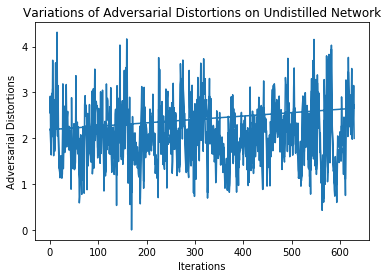

In [0]:
# plotting the metrics
plt.plot(iterations, distortions)
plt.title('Variations of Adversarial Distortions on Undistilled Network')
plt.ylabel('Adversarial Distortions')
plt.xlabel('Iterations')
plt.show()

###**Execute L2 Adversarial Attacks on the Defensively Distilled Neural Network**

In [0]:
distortions = []
iterations = []

with tf.Session() as sess:
    data, model =  MNIST(), MNISTModel("models/mnist-distilled-100", sess)
    attack = l2_attack(sess, model, batch_size = 9, max_iterations = 1000, confidence = 0)
    inputs, targets = generate_data(data, samples=70, targeted = True, start = 0, inception = False)
    start_time = time.time()
    adv = attack.attack(inputs, targets) #Get the set of 630 adversarial Images
    np.save("adv_distilled",adv)
    print(adv.shape)
    print("--- Adversarial Examples Generation Time: %s seconds ---" % (time.time() - start_time))
    for i in range(len(adv)):
        print("Classification:", model.model.predict(adv[i:i+1]))
        distortion = np.sum((adv[i]-inputs[i])**2)** 0.5
        print("Total distortion:", distortion)
        iterations.append(i)
        distortions.append(distortion)

go up to 630
tick 0
o_bestl2 [10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
Losses:   0 (24.366688, 24.357983, 0.008705986)
Losses:   100 (23.159512, 21.837336, 1.322175)
Losses:   200 (23.098421, 21.547703, 1.5507181)
Losses:   300 (21.641163, 17.813646, 3.827517)
Losses:   400 (21.523602, 17.632242, 3.8913584)
Losses:   500 (21.506361, 17.608583, 3.8977776)
Losses:   600 (21.50226, 17.600134, 3.9021258)
Losses:   700 (21.50105, 17.600105, 3.900945)
o_bestl2 [10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0, 10000000000.0]
Losses:   0 (243.58852, 243.5798, 0.008708776)
Losses:   100 (143.86656, 103.60644, 40.26012)
Losses:   200 (113.19824, 54.02044, 59.177803)
Losses:   300 (69.544495, 15.699701, 53.844795)
Losses:   400 (59.609417, 10.934807, 48.67461)
Losses:   500 (57.71327, 9.840927, 47.87234)
Losses:   600 (56.912346, 9.50

###**Variations of Distortions on Defensively Distilled Network**

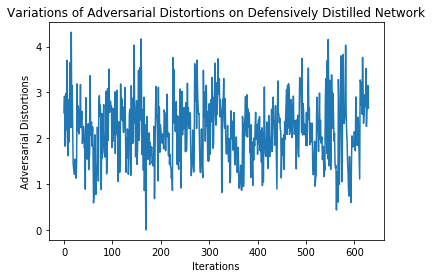

In [0]:
# plotting the metrics
plt.plot(iterations, distortions)
plt.title('Variations of Adversarial Distortions on Defensively Distilled Network')
plt.ylabel('Adversarial Distortions')
plt.xlabel('Iterations')
plt.show()

###**Evaluate Results**
####**Classify and Store Adversarial Images for Undistilled Network**

In [0]:
adv = np.load('adv.npy')
ip = np.load('ip_img.npy')
labels = np.load('labels.npy')
digits = np.arange(0,10)
flags = np.zeros(10)

if not os.path.exists("results"):
    os.mkdir("results")

with tf.Session() as sess:
    data, model =  MNIST(), MNISTModel("models/mnist", sess)
    for i in range(0, 69):
        c = 9 * i
        l = model.model.predict(ip[c: c+1])
        index = np.argmax(l)
        print(i)
        print(l)
        print(index)
        print("next")

        if flags[index] == 0:
            if not os.path.exists("results/"+ str(index)):
                os.mkdir("results/" + str(index))

            for j in range(10):
                I = adv[c+j][:,:,0]
                I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
                img = Image.fromarray(I8)
                img.save("results/" + str(index) + "/" + str(j) + ".png")
                #plt.imsave("results/" + str(index) + "/" + str(j), adv[c+j][:,:,0])
        
        flags[index] = 1
        if np.sum(flags) == 10:
            break

0
[[ -9.194922    0.4179989   1.7583742  -3.388443    1.4610326  -7.236525
  -16.54426    31.442537  -10.743509    1.171406 ]]
7
next
1
[[  7.373092    4.416197   41.159378   -7.8466325  -7.194223  -18.130207
   -1.0241623  -7.0265865  -2.4967687 -14.528032 ]]
2
next
2
[[ -3.8875024   23.1349      -4.831762   -11.577909     3.8984962
   -0.4856038   -0.6992403   -3.1008534   -0.46125767  -5.571145  ]]
1
next
3
[[ 30.735077  -11.031974   -0.5787306 -15.513826   -5.934042   -3.780163
    8.70386    -5.8602157  -3.2476723  -0.8720591]]
0
next
4
[[-10.574737    1.2845178  -6.8456373 -14.287515   41.533962   -7.3362207
   -8.156588   -3.9923172  -1.3355207  11.56141  ]]
4
next
5
[[ -4.512528   28.118773   -4.7095485 -14.627948    4.5777645  -2.00078
   -2.6198277  -1.777494   -1.337038   -6.6357794]]
1
next
6
[[-21.05499      3.161899    -9.1888275  -16.209576    36.62601
   -5.3261824  -10.412805     0.60513854   8.8084345   11.594343  ]]
4
next
7
[[ -7.1945477  -6.7767153  -4.8546314   2.

####**Classify and Store Adversarial Images for Defensively distilled Network**

In [0]:
adv = np.load('adv_distilled.npy')
ip = np.load('ip_img.npy')
labels = np.load('labels.npy')
digits = np.arange(0,10)
flags = np.zeros(10)

if not os.path.exists("distilled_results"):
    os.mkdir("distilled_results")

with tf.Session() as sess:
    data, model =  MNIST(), MNISTModel("models/mnist-distilled-100", sess)
    for i in range(0, 69):
        c = 9 * i
        l = model.model.predict(ip[c: c+1])
        index = np.argmax(l)
        print(i)
        print(l)
        print(index)
        print("next")

        if flags[index] == 0:
            if not os.path.exists("distilled_results/"+ str(index)):
                os.mkdir("distilled_results/" + str(index))

            for j in range(10):
                I = adv[c+j][:,:,0]
                I8 = (((I - I.min()) / (I.max() - I.min())) * 255.9).astype(np.uint8)
                img = Image.fromarray(I8)
                img.save("distilled_results/" + str(index) + "/" + str(j) + ".png")
        
        flags[index] = 1
        if np.sum(flags) == 10:
            break

0
[[   -6.955731   215.64699    175.28728    112.318054  -564.47455
   -270.0269   -1408.0222    2533.2742    -360.6022     431.49695 ]]
7
next
1
[[ 1042.1681    913.55743  3373.6453   -355.78482  -664.8079  -1554.647
    487.7572   -650.7685    253.67052 -1129.439  ]]
2
next
2
[[-417.5823   1788.2052    -72.12489  -537.61224   371.34836  -351.6132
   -14.784695  220.76749   174.2526   -353.8584  ]]
1
next
3
[[2547.6682  -931.9746    43.9152  -993.28046 -216.34361 -138.32373
   735.14856 -292.33575 -233.98479  482.31064]]
0
next
4
[[ -303.3232   -292.6385   -288.49545 -1285.5629   2762.569    -462.63562
    190.90543  -841.83405   -72.64853   979.99554]]
4
next
5
[[-485.30002 2286.3289  -222.39578 -770.51807  542.149   -630.27356
  -146.89774  454.1603   199.93726 -266.64352]]
1
next
6
[[-1384.0693    253.37668  -740.795    -770.4952   2018.1852   -248.42674
   -285.49542   -31.35836  1199.7495   1050.7777 ]]
4
next
7
[[-434.77542 -806.5726  -412.0198   862.57446  280.9936   495.86868
